# 9주차

#### ** 신경망 만들기 **

### 1. 텐서를 다루다

* 현재까지는  x 가 텐서일경우, sin함수가 원소별로 적용됨

In [1]:
import numpy as np
from dezero import Variable
import dezero.functions as F

x = Variable(np.array([[1,2,3],[4,5,6]]))
y = F.sin(x)
print(y)

variable([[ 0.84147098  0.90929743  0.14112001]
          [-0.7568025  -0.95892427 -0.2794155 ]])


* sum 함수를 사용하면 주어진 텐서에의 모든원소의 총합을 구해 하나의 스칼라로 출력함

In [2]:
x = Variable(np.array([[1, 2, 3], [4, 5, 6]]))
c = Variable(np.array([[10, 20, 30], [40, 50, 60]]))
t = x + c
print(t)
y = F.sum(t)
print(y)

variable([[11 22 33]
          [44 55 66]])
variable(231)


* 순전파 때의 shape와 기울기의 shape가 일치하다

In [3]:
y.backward(retain_grad=True)
print(y.grad)
print(t.grad)
print(x.grad)
print(c.grad)

variable(1)
variable([[1 1 1]
          [1 1 1]])
variable([[1 1 1]
          [1 1 1]])
variable([[1 1 1]
          [1 1 1]])


### 2. 형상 변환 함수

* 텐서의 형상을 바꾸는 함수 **reshape**

In [4]:
x = Variable(np.array([[0, 1, 2], [3, 4, 5]]))
y = F.reshape(x, (6,)) 
print(y)

variable([0 1 2 3 4 5])


* reshape 함수 구현(Dezero용)

In [5]:
class Reshape(Function):
    def __init__(self, shape):
        self.shape = shape

    def forward(self, x):
        self.x_shape = x.shape
        y = x.reshape(self.shape)
        return y

    def backward(self, gy):
        return reshape(gy, self.x_shape)

NameError: name 'Function' is not defined

In [ ]:
from dezero.core import as_variable
def reshape(x, shape):
    if x.shape == shape:
        return as_variable(x)
    return Reshape(shape)(x)

* 구현한 reshape 함수 사용

* Variable에서 reshape 사용

In [6]:
x = np.random.rand(1,2,3)

y = x.reshape((2,3)) #튜플로
y

array([[0.75861957, 0.02576439, 0.85813447],
       [0.22708905, 0.59115909, 0.38882194]])

* 행렬을 전치해주는 함수 구현

In [ ]:
class Transpose(Function):
    def forward(self,x):
        y = np.transpose(x)
        return y
    def backward(self, gy): #기울기는 그대로고 gy값을 넣어주면 된다
        gx = transpose(gy)
        return gx
def transpose(x):
    return Transpose()(x)

In [ ]:
import numpy as np
from dezero import Variable
import dezero.functions as F

* 테스트

In [ ]:
x = Variable(np.array([[1, 2, 3], [4, 5, 6]]))
y = F.transpose(x)  # y = x.T
y.backward()
print(y)

* T로 전치 구현

In [ ]:
y = x.T
print(y)

In [ ]:
x = Variable(np.random.rand(2,3))
y = x.T
print(y)

앞 step들을 구현해오다보니 reshape와 transpose 함수 구현은 간단히 느껴진다.

### sum 함수의 역전파

In [ ]:
class Sum(Function):
    def forward(self,x):
        self.x_shape = x.shape
        y = x.sum()
        return y
    def backward(self,gy):
        gx = broadcast_to(gy,self.x_shape)
        return gx
    
def sum(x):
    return Sum()(x)

* axis와 keepdims 추가

In [ ]:
# 합계를 구할 때 축을 지정할 수 있는 인수 axis
x = Variable(np.array([[1, 2, 3], [4, 5, 6]]))
y = F.sum(x, axis=0) # 1
y.backward()
print(y)
print(x.grad)

In [ ]:
# 차원 수 유지할 지 정하는 인수 keepdims
x = np.array([[1,2,3],[4,5,6]])
y = np.sum(x, keepdims=True)
print(y)

* broadcast <br>
: 서로 다른 shape을 가진 배열들간에 산술 연산을 위해 구현

In [ ]:
x = np.array([1,2,3])
y = np.broadcast_to(x,(4,3))    # (복제,기존형상)
y = y.sum(axis=1)
print(y)

* sum_to<br>
: sum_to(x,shape) -> shape가 shape가 되도록 합을 계산

In [ ]:
def sum_to(x, shape):
    """Sum elements along axes to output an array of a given shape.

    Args:
        x (ndarray): Input array.
        shape:

    Returns:
        ndarray: Output array of the shape.
    """
    ndim = len(shape)
    lead = x.ndim - ndim
    lead_axis = tuple(range(lead))

    axis = tuple([i + lead for i, sx in enumerate(shape) if sx == 1])
    y = x.sum(lead_axis + axis, keepdims=True)
    if lead > 0:
        y = y.squeeze(lead_axis)
    return y

In [ ]:
from dezero.utils import sum_to

x = np.array([[1,2,3],[4,5,6]])
y = sum_to(x,(1,3))
print(y)
y = sum_to(x,(2,1))
print(y)

* BroadcastTo 클래스<br>
: 역전파시 입력 x와 shape을 일치하도록 기울기의 원소를 복제해야함<br>
이를 위해 사용

In [ ]:
class BroadcastTo(Function):
    def __init__(self, shape):
        self.shape = shape

    def forward(self, x):
        self.x_shape = x.shape
        xp = dezero.cuda.get_array_module(x)
        y = xp.broadcast_to(x, self.shape)
        return y

    def backward(self, gy):
        gx = sum_to(gy, self.x_shape)
        return gx


def broadcast_to(x, shape):
    if x.shape == shape:
        return as_variable(x)
    return BroadcastTo(shape)(x)

In [ ]:
x0 = Variable(np.array([1, 2, 3]))
x1 = Variable(np.array([10]))
y = x0 + x1
print(y)

* 브로드캐스트 역전파 계산

순전파때 브로드캐스트가 일어난다면 입력되는 x0와 x1의 형상이 다르다는 것임

In [ ]:
# 기울기 gx0는 x0의 형상이 되도록 합을 구하고, 
# 기울기 gx1은 x1의 형상이 되록 합을 구함

class Add(Function):
    def forward(self, x0, x1):
        self.x0_shape, self.x1_shape = x0.shape, x1.shape
        y = x0 + x1
        return y

    def backward(self, gy):
        gx0, gx1 = gy, gy
        if self.x0_shape != self.x1_shape:  # for broadcaset
            gx0 = dezero.functions.sum_to(gx0, self.x0_shape) 
            gx1 = dezero.functions.sum_to(gx1, self.x1_shape)
        return gx0, gx1

In [ ]:
x0 = Variable(np.array([1, 2, 3]))
x1 = Variable(np.array([10]))
y = x0 + x1
print(y)

y.backward()
print(x1.grad)

### 벡터의 내적과 행렬의곱

벡터의 내적: 
 두 벡터 사이의 대응 원소의 곱을 모두 합한 값이 벡터의 내적임


* 행렬의 곱 계산 방법은 **np.dot** 함수

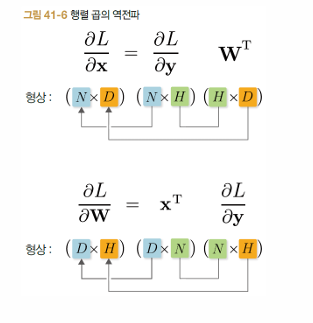

In [23]:
import numpy as np
from dezero import Variable
import dezero.functions as F

In [2]:
class MatMul(Function):
    def forward(self, x, W):
        y = x.dot(W)
        return y

    def backward(self, gy):
        x, W = self.inputs
        gx = matmul(gy, W.T)  # 행렬곱의 역전파 계산에 따라
        gW = matmul(x.T, gy)
        return gx, gW


def matmul(x, W):
    return MatMul()(x, W)

NameError: name 'Function' is not defined

In [2]:
x = Variable(np.random.randn(2, 3))
w = Variable(np.random.randn(3, 4))
y = F.matmul(x, w)
y.backward()

print(x.grad.shape) # 순전파 때와 shape가 동일하게 출력
print(w.grad.shape)

(2, 3)
(3, 4)


# 8장


### 신경망 만들기

#### 1. 선형 회귀

* 토이 데이터셋으로 예측 모델

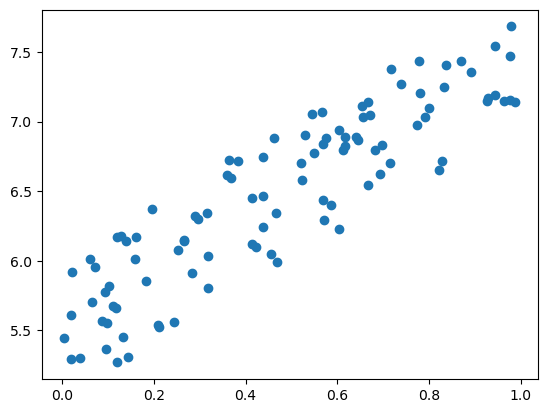

In [7]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)
x = np.random.rand(100,1)
y = 5 + 2 * x + np.random.rand(100,1)

plt.scatter(x,y); plt.show()

* 예측 모델의 목표
1)   y와 x가 선형관계라고가정하여, y = Wx + b 식으로 표현할 수있음

* MSE


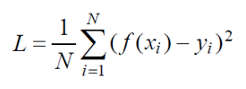

 [식 42.1] 로 표현되는 손실 함수의 출력을
최소화하는W와b를찾는것

* 데이터의 예측치를 구하는 predict 함수 구현

In [2]:
W = Variable(np.zeros((1, 1)))
b = Variable(np.zeros(1))


def predict(x):
    y = F.matmul(x, W) + b
    return y

* 평균 제곱 오차를 구하는 함수

In [3]:
def mean_squared_error(x0, x1):
    diff = x0 - x1
    return F.sum(diff ** 2) / len(diff)
# 매개변수를 갱신할때 W.data -= lr * W.grad.data 처럼

In [4]:
import numpy as np
from dezero import Variable
import dezero.functions as F

In [8]:
np.random.seed(0)
x = np.random.rand(100,1)
y = 5 + 2 * x + np.random.rand(100,1)
x,y = Variable(x), Variable(y)
W = Variable(np.zeros((1, 1)))
b = Variable(np.zeros(1))

lr = 0.1
iters = 10 # 100도 해봄

for i in range(iters):
    y_pred = predict(x)
    loss = mean_squared_error(y, y_pred)

    W.cleargrad()
    b.cleargrad()
    loss.backward()

    W.data -= lr * W.grad.data
    b.data -= lr * b.grad.data
    print(W, b, loss) 
# iters = 10일 때, loss가 42에서 0.4까지 줄음

variable([[0.64433458]]) variable([1.29473389]) variable(42.296340129442335)
variable([[1.12672345]]) variable([2.26959351]) variable(23.97380754378544)
variable([[1.48734571]]) variable([3.00386712]) variable(13.609686745040522)
variable([[1.75641886]]) variable([3.557186]) variable(7.747049961219976)
variable([[1.95666851]]) variable([3.97439789]) variable(4.43057410592155)
variable([[2.10518573]]) variable([4.28923203]) variable(2.5542803813535926)
variable([[2.21482401]]) variable([4.52705574]) variable(1.4925998690471942)
variable([[2.29524981]]) variable([4.70694745]) variable(0.8916952181756932)
variable([[2.35373273]]) variable([4.84325585]) variable(0.5514270962227453)
variable([[2.39573972]]) variable([4.9467725]) variable(0.35859153083192785)


* mse 함수 구현의 문제점

중간에 등장하는 변수들이 메모리에 계속 살아 있음
<br> -> 얘네 변수의 ndarray도 살아있음 그러기에 메모리 최적화를 위해 수정

개선안
1. ndarray 구현 , 순전파는 거의 동일
2. 수식으로 미분을 계산한 뒤, 수식을 코드로 구현
3. forward 메서드에서만 **ndarray 구현**

In [9]:
def mean_squared_error(x0, x1):
    diff = x0 - x1
    return F.sum(diff ** 2) / len(diff)

위 코드에서 아래와 같이 수정

In [ ]:
class MeanSquaredError(Function):
    def forward(self, x0, x1):
        diff = x0 - x1
        y = (diff ** 2).sum() / len(diff)
        return y

    def backward(self, gy):
        x0, x1 = self.inputs
        diff = x0 - x1
        gx0 = gy * diff * (2. / len(diff))
        gx1 = -gx0
        return gx0, gx1


def mean_squared_error(x0, x1):
    return MeanSquaredError()(x0, x1)

### 2. 선형회귀 구현을 신경망 확장

* linear 함수

선형변환을 linear 함수로 구현하는 방식:<br><br>
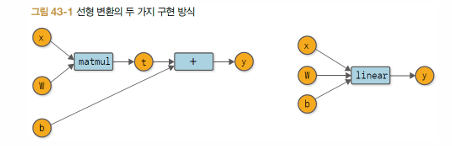


linear 함수가 더 메모리 효율적으로 씀

*  linear_simple 함수

In [21]:
def linear_simple(x, W, b=None):
    t = F.matmul(x, W) 
    if b is None:
        return t # 단순히 행렬 곱셈만 계산하여 반환

    y = t + b
    t.data = None  # t 데이터를 메모리에서 삭제
    return y

* 비선형 데이터셋 생성

선형회귀로는 문제를 풀수없음

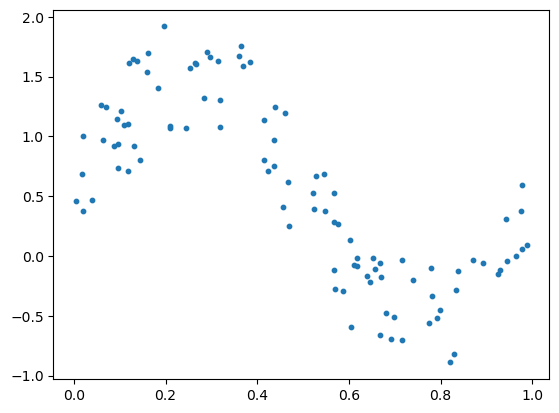

In [15]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(0)
x = np.random.rand(100, 1)
y = np.sin(2 * np.pi * x) + np.random.rand(100, 1)

plt.scatter(x, y, s=10)
plt.show()

* 활성화 함수
1. 시그모이드

In [2]:
def sigmoid_simple(x):
    x = as_variable(x)
    y = 1 / (1 + np.exp(-x))
    return y

**신경망추론코드**
<br><br>
연속적으로 변환을 수행하는 일반적인 신경망 형태
<br><br>->신경망 학습에서는 추론을 처리한 후 손실함수를 추가
<br><br>->손실함수의 출력을 최소화하는 매개변수를 찾음
<br><br>->선형변환이나 활성화함수 등에 의한 변환을 층(Layer)라고함

* 신경망 구현

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from dezero import Variable
import dezero.functions as F

In [6]:
np.random.seed(0)
x = np.random.rand(100, 1)
y = np.sin(2 * np.pi * x) + np.random.rand(100, 1)

I, H, O = 1, 10, 1
W1 = Variable(0.01 * np.random.randn(I, H))
b1 = Variable(np.zeros(H))
W2 = Variable(0.01 * np.random.randn(H, O))
b2 = Variable(np.zeros(O))

def predict(x):
    y = F.linear(x, W1, b1)
    y = F.sigmoid(y)
    y = F.linear(y, W2, b2)
    return y


lr = 0.2
iters = 10000

for i in range(iters):
    y_pred = predict(x)
    loss = F.mean_squared_error(y, y_pred)

    W1.cleargrad()
    b1.cleargrad()
    W2.cleargrad()
    b2.cleargrad()
    loss.backward()

    W1.data -= lr * W1.grad.data
    b1.data -= lr * b1.grad.data
    W2.data -= lr * W2.grad.data
    b2.data -= lr * b2.grad.data
    if i % 1000 == 0:
        print('loss:', loss)

loss: variable(0.8473695850105871)
loss: variable(0.2514286285183606)
loss: variable(0.2475948546674987)
loss: variable(0.2378612044705482)
loss: variable(0.21222231333102926)
loss: variable(0.16742181117834185)
loss: variable(0.09681932619992682)
loss: variable(0.07849528290602334)
loss: variable(0.07749729552991155)
loss: variable(0.07722132399559316)


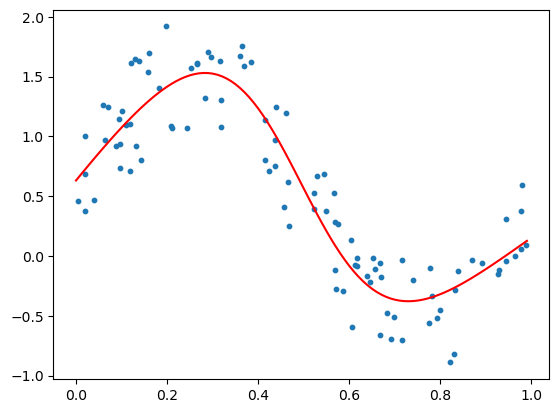

In [12]:
plt.scatter(x, y, s=10)
t = np.arange(0, 1, .01)[:, np.newaxis]
y_pred = predict(t)
plt.plot(t, y_pred.data, color='r')

* 사용 편의성 개선
<br>
<br> 지금까지의 문제:
<br>
층이 깊어질 수록 매개변수관리가 번거로워짐 
<br>-> 매개변수관리를간소화
<br>-> 매개변수를담는구조를만듬
<br>->  Parameter와 Layer 라는 클래스를 구현

* Parameter 클래스

 Parameter 인스턴스와 Variable 인스턴스를 조합하여 계산할 수 있음

In [1]:
class Parameter(Variable):
    pass

NameError: name 'Variable' is not defined

* Layer 클래스

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dezero import Variable
import dezero.functions as F
import weakref


from dezero.core import Parameter


class Layer:            # 매개변수를 인스턴스변수_params 저장
    def __init__(self):
        self._params = set()    

    def __setattr__(self,name,value):
        if isinstance(value.Parameter):
            self._params.add(name)   # name을 추가해 Layer 클래스가 갖는 매개변수를 인스턴수 변수_params에 모아둘 수있음
        super().__setattr__(name, value)


    def __call__(self, *inputs):                # 입력과 출력변수를 약한참조로 유지
        outputs = self.forward(*inputs)
        if not isinstance(outputs, tuple):  
            outputs = (outputs,)
        self.inputs = [weakref.ref(x) for x in inputs]
        self.outputs = [weakref.ref(y) for y in outputs]
        return outputs if len(outputs) > 1 else outputs[0] #출력이 하나뿐이라면 튜플이아니라 그출력을 직접 반환

    def forward(self, inputs):
        raise NotImplementedError()

    def params(self):               #  Layer 인스턴스에 담겨 있는 Parameter 인스턴스들을꺼내줌
        for name in self._params:
            obj = self.__dict__[name]

            if isinstance(obj, Layer):
                yield from obj.params()             # 작업 재개
            else:
                yield obj                          # 처리를 일시중지하고 값을 반환

    def cleargrads(self):       # 모든 매개변수의 기울기를 재설정
        for param in self.params():
            param.cleargrad()

* Linear 클래스 구현

In [ ]:
class Linear(Layer):
    def __init__(self, in_size, out_size, nobias=False, dtype=np.float32):
        super().__init__()

        I, O = self.in_size, self.out_size
        W_data = np.random.randn(I, O).astype(self.dtype) * np.sqrt(1 / I)
        self.W = Parameter(None, name='W')     
        if nobias:
            self.b = None
        else:
            self.b = Parameter(np.zeros(out_size, dtype=dtype), name='b')

    def forward(self, x):
        y = F.linear(x, self.W, self.b)
        return y    

*  Linear 클래스 구현하는 더 나은 방법


In [ ]:
class Linear(Layer):
    def __init__(self, out_size, nobias=False, dtype=np.float32, in_size=None):
        super().__init__()
        self.in_size = in_size
        self.out_size = out_size
        self.dtype = dtype

        self.W = Parameter(None, name='W')
        if self.in_size is not None:
            self._init_W()

        if nobias:
            self.b = None
        else:
            self.b = Parameter(np.zeros(out_size, dtype=dtype), name='b')

    def _init_W(self, xp=np):
        I, O = self.in_size, self.out_size
        W_data = xp.random.randn(I, O).astype(self.dtype) * np.sqrt(1 / I)
        self.W.data = W_data

    def forward(self, x):
        if self.W.data is None:
            self.in_size = x.shape[1]
            xp = cuda.get_array_module(x)
            self._init_W(xp)

        y = F.linear(x, self.W, self.b)
        return y

* Linear 클래스를 이용하여 신경망을 구현

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dezero import Variable
import dezero.functions as F
import weakref

import dezero.layers as L       


np.random.seed(0)
x = np.random.rand(100, 1)
y = np.sin(2 * np.pi * x) + np.random.rand(100, 1)

l1 = L.Linear(10)       # 매개변수관리를 Linear 인스턴스가 맡고있음
l2 = L.Linear(1)


def predict(x):
    y = l1(x)
    y = F.sigmoid(y)
    y = l2(y)
    return y


lr = 0.2
iters = 10000

for i in range(iters):
    y_pred = predict(x)
    loss = F.mean_squared_error(y, y_pred)

    l1.cleargrads()
    l2.cleargrads()
    loss.backward()

    for l in [l1, l2]:
        for p in l.params():
            p.data -= lr * p.grad.data
    if i % 1000 == 0:
        print(loss)

variable(0.8165178492839196)
variable(0.24990280802148895)
variable(0.24609876581126014)
variable(0.2372159081431807)
variable(0.20793216413350174)
variable(0.12311905720649353)
variable(0.07888166506355151)
variable(0.07655073683421636)
variable(0.07637803086238223)
variable(0.0761876413118557)


매개변수를 사용자가 직접 다루지않아도 되어 편리함

* 새로운 Layer 클래스 구조 <br>

: Layer 클래스 안에 다른 Layer 가 들어가는 구조

* 새로운 Layer 클래스를 사용하여 신경망 구현

TwoLayerNet에 신경망에 필요한 모든 코드를 집약 가능

In [ ]:
class TwoLayerNet(Model):
    def __init__(self, hidden_size, out_size):
        super().__init__()
        self.l1 = L.Linear(hidden_size)
        self.l2 = L.Linear(out_size)

    def forward(self, x):       # 추론을 수행
        y = F.sigmoid(self.l1(x))
        y = self.l2(y)
        return y


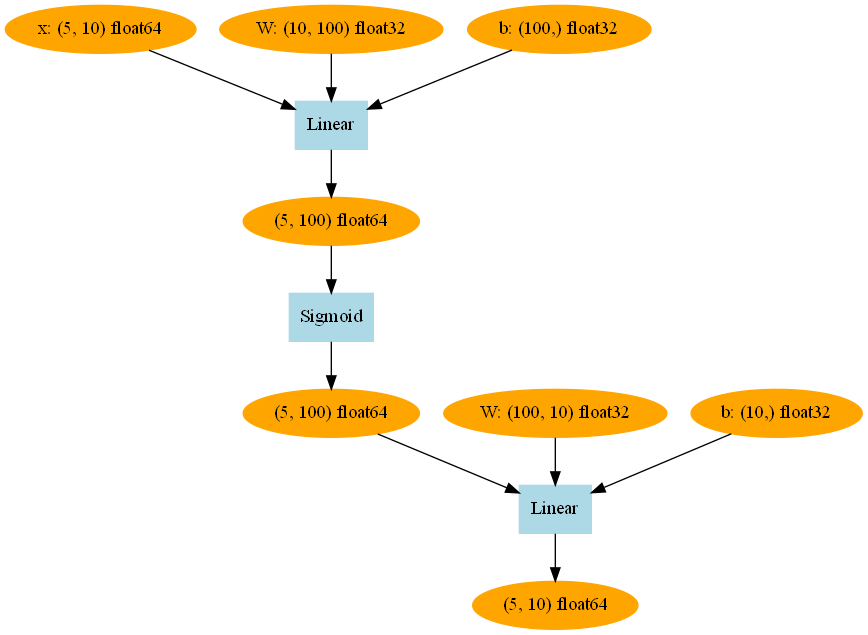

In [2]:
from dezero import Variable, Model
import dezero.functions as F
import dezero.layers as L
import numpy as np       


class TwoLayerNet(Model):
    def __init__(self, hidden_size, out_size):
        super().__init__()
        self.l1 = L.Linear(hidden_size)
        self.l2 = L.Linear(out_size)

    def forward(self, x):
        y = F.sigmoid(self.l1(x))
        y = self.l2(y)
        return y

x = Variable(np.random.randn(5,10), name='x')
model = TwoLayerNet(100,10)
model.plot(x)

Model 클래스를 이용하여 다시 풀어봄

In [7]:
np.random.seed(0)
x = np.random.rand(100, 1)
y = np.sin(2 * np.pi * x) + np.random.rand(100, 1)

lr = 0.2
max_iter = 10000
hidden_size = 10

for i in range(max_iter):
    y_pred = model(x)
    loss = F.mean_squared_error(y, y_pred)

    model.cleargrads()
    loss.backward()

    for p in model.params():
        p.data -= lr * p.grad.data
    if i % 1000 == 0:
        print(loss)

ValueError: shapes (100,1) and (10,100) not aligned: 1 (dim 1) != 10 (dim 0)

* 완전연결계층 신경망 구현

In [ ]:
class MLP(Model):
    def __init__(self, fc_output_sizes, activation=F.sigmoid):  #  출력 크기를 튜플 또는 리스트로 지정함
        super().__init__()
        self.activation = activation
        self.layers = []

        for i, out_size in enumerate(fc_output_sizes):
            layer = L.Linear(out_size)
            setattr(self, 'l' + str(i), layer)
            self.layers.append(layer)

    def forward(self, x):
        for l in self.layers[:-1]:
            x = self.activation(l(x))
        return self.layers[-1](x)

소감 : MLP를 통해 모든 신경망을 구현하는 과정이 몇줄 안되어보이지만
많은 공부가 필요한 것 같다. 